**GPU**

In [1]:
import tensorflow as tf

# Check for GPU availability
print("GPU available:", tf.config.list_physical_devices('GPU'))

# Test GPU computation
with tf.device('/GPU:0'):
    a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
    b = tf.constant([[5.0, 6.0], [7.0, 8.0]])
    c = tf.matmul(a, b)

print("Matrix multiplication result:", c)
print("Computation performed on:", c.device)


GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Matrix multiplication result: tf.Tensor(
[[19. 22.]
 [43. 50.]], shape=(2, 2), dtype=float32)
Computation performed on: /job:localhost/replica:0/task:0/device:GPU:0


In [2]:
# Run this in your Python environment
import subprocess
try:
    output = subprocess.check_output('nvidia-smi', shell=True)
    print(output.decode())
except:
    print("nvidia-smi command failed - you may not have an NVIDIA GPU or drivers installed")

Sun May 25 22:47:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.40                 Driver Version: 576.40         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| 60%   52C    P0             56W /  125W |    5320MiB /   6144MiB |     21%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # Show all logs
import tensorflow as tf
print("CUDA available:", tf.test.is_built_with_cuda())

CUDA available: True


In [4]:
import tensorflow as tf
# Check for GPU availability and configure it
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU(s) detected: {gpus}")
    # Configure GPU to use memory dynamically (prevents OOM errors)
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("Memory growth enabled on GPU")
        except RuntimeError as e:
            print(f"Error setting memory growth: {e}")
else:
    print("No GPU detected - training will use CPU (much slower)")

# Optional: Set maximum GPU memory to use (if needed)
# tf.config.set_logical_device_configuration(
#     gpus[0],
#     [tf.config.LogicalDeviceConfiguration(memory_limit=10*1024)]  # 10GB limit
# )

GPU(s) detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Error setting memory growth: Physical devices cannot be modified after being initialized


**Load Dataset**

Dataset found at Philippine Medicinal Plant Leaf Dataset
Found 4971 files belonging to 40 classes.
Using 3977 files for training.
Found 4971 files belonging to 40 classes.
Using 994 files for validation.
Number of classes: 40
Class names: ['10Coleus scutellarioides(CS)', '11Phyllanthus niruri(PN)', '12Corchorus olitorius(CO)', '13Momordica charantia (MC)', '14Euphorbia hirta(EH)', '15Curcuma longa(CL)', '16Carmona retusa(CR)', '17Senna alata(SA)', '18Mentha cordifolia Opiz(MCO)', '19Capsicum frutescens(CF)', '1Hibiscus rosa-sinensis(HRS)', '20Jatropha curcas(JC)', '21Ocimum basilicum(OB)', '22Nerium oleander(NO)', '23Pandanus amaryllifolius(PA)', '24Aloe barbadensis Miller(ABM)', '25Lagerstroemia speciosa(LS)', '26Averrhoea bilimbi(AVB)', '27Annona muricata(AM)', '28Citrus aurantiifolia(CIA)', '29Premna odorata(PO)', '2Psidium guajava(PG)', '30Gliricidia sepium(GS)', '31Citrus sinensis(CIS)', '32Mangifera indica(MI)', '33Citrus microcarpa(CM)', '34Impatiens balsamina(IB)', '35Arachis h

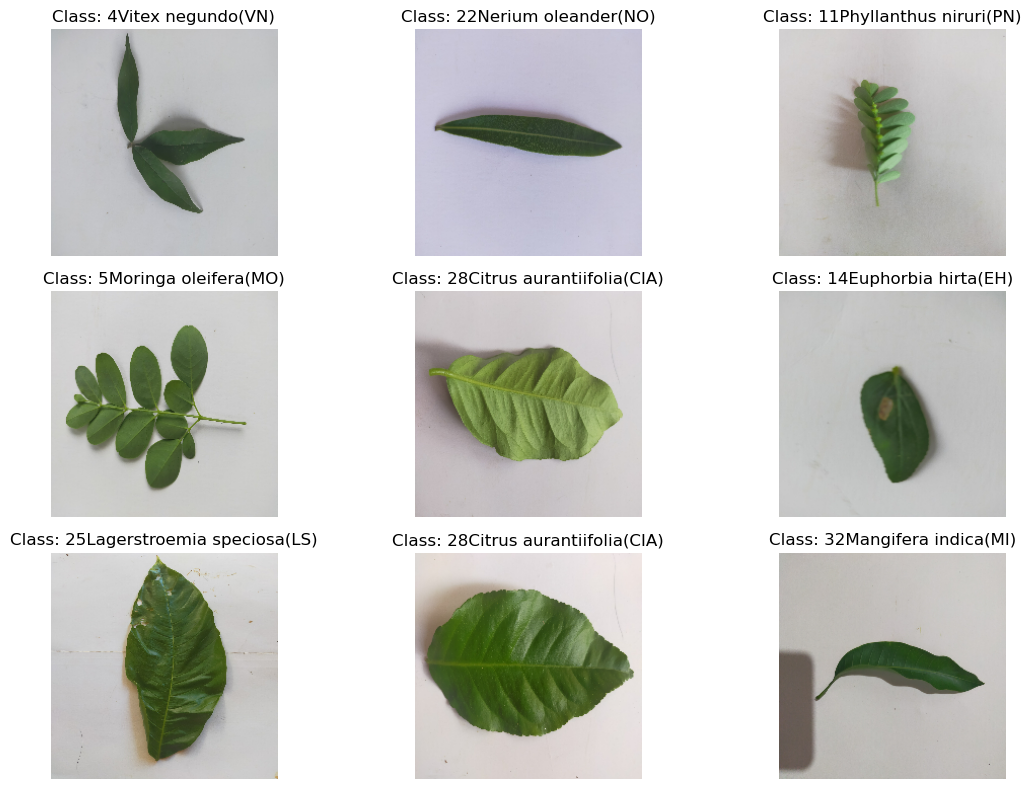

Dataset loaded and preprocessed successfully!
Ready for model training.


In [5]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

# Set up the dataset path
# After downloading from Kaggle, extract and set the correct path
dataset_path = "Philippine Medicinal Plant Leaf Dataset"  # Update this path

# Check if dataset exists
if not os.path.exists(dataset_path):
    print(f"Dataset not found at {dataset_path}")
    print("Please download the dataset from:")
    print("https://www.kaggle.com/datasets/jaydepaolomirandilla/philippine-medicinal-plant-leaf-dataset")
    print("And extract it to the current directory")
else:
    print(f"Dataset found at {dataset_path}")

# 1. Load your image dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,          # 20% for validation
    subset="training",
    seed=123,
    image_size=(224, 224),         # resize images to standard size for transfer learning
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Get class information
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# Display dataset information
train_batches = tf.data.experimental.cardinality(train_ds).numpy()
val_batches = tf.data.experimental.cardinality(val_ds).numpy()

print(f"Training batches: {train_batches}")
print(f"Validation batches: {val_batches}")
print(f"Approximate training images: {train_batches * 32}")
print(f"Approximate validation images: {val_batches * 32}")

# Performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Optional: Add data augmentation for better training
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Apply normalization (important for pre-trained models)
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Function to visualize some samples
def visualize_samples(dataset, class_names, num_samples=9):
    plt.figure(figsize=(12, 8))
    
    for images, labels in dataset.take(1):
        for i in range(min(num_samples, len(images))):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"Class: {class_names[labels[i]]}")
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Visualize some samples
print("\nVisualizing sample images...")
visualize_samples(train_ds, class_names)

# Create augmented dataset for training (optional)
def prepare_for_training(ds, augment=False):
    # Apply normalization
    ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
    
    # Apply data augmentation if specified
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                   num_parallel_calls=AUTOTUNE)
    
    return ds

# Apply preprocessing
train_ds_processed = prepare_for_training(train_ds, augment=True)
val_ds_processed = prepare_for_training(val_ds, augment=False)

print("Dataset loaded and preprocessed successfully!")
print("Ready for model training.")

**CNN Algorithm**

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

print("✅ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

✅ All libraries imported successfully!
TensorFlow version: 2.10.0


**Data Preprocessing and Optimization**

In [7]:
# Performance optimization for data pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

print("🚀 Data pipeline optimized with prefetching")
print(f"Training dataset: {train_ds}")
print(f"Validation dataset: {val_ds}")

🚀 Data pipeline optimized with prefetching
Training dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Validation dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


**CNN Model Architecture**

In [8]:
# Build the Convolutional Neural Network model
model = tf.keras.Sequential([
    # Input layer - normalize pixel values to [0,1] range
    tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    
    # First convolutional block
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    # Second convolutional block
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    # Third convolutional block
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    # Flatten feature maps for dense layers
    tf.keras.layers.Flatten(),
    
    # Fully connected layers
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer
])

print("🏗️ CNN Model Architecture Created")

🏗️ CNN Model Architecture Created


**Model Compilation**

In [9]:
# Compile the model with optimizer, loss function, and metrics
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("⚙️ Model compiled successfully!")
print("\n📋 Model Architecture Summary:")
model.summary()

⚙️ Model compiled successfully!

📋 Model Architecture Summary:
Model: "sequential_1"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
          

**Model Training**

In [10]:
# Train the CNN model
print(f"🎯 Starting training on {num_classes} Philippine medicinal plant classes...")
print("=" * 60)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1
)

print("✅ Training completed!")

🎯 Starting training on 40 Philippine medicinal plant classes...
Epoch 1/20
125/125 [==============================] - 152s 1s/step - loss: 2.4820 - accuracy: 0.3389 - val_loss: 1.3628 - val_accuracy: 0.6177
Epoch 2/20
125/125 [==============================] - 92s 681ms/step - loss: 0.9024 - accuracy: 0.7382 - val_loss: 0.8232 - val_accuracy: 0.7475
Epoch 3/20
125/125 [==============================] - 93s 712ms/step - loss: 0.4407 - accuracy: 0.8635 - val_loss: 0.7685 - val_accuracy: 0.7897
Epoch 4/20
125/125 [==============================] - 98s 748ms/step - loss: 0.2634 - accuracy: 0.9163 - val_loss: 0.6141 - val_accuracy: 0.8270
Epoch 5/20
125/125 [==============================] - 91s 695ms/step - loss: 0.1512 - accuracy: 0.9507 - val_loss: 0.7539 - val_accuracy: 0.8310
Epoch 6/20
125/125 [==============================] - 91s 691ms/step - loss: 0.1238 - accuracy: 0.9635 - val_loss: 1.2524 - val_accuracy: 0.7716
Epoch 7/20
125/125 [==============================] - 93s 704ms/step

**Training History Visualization Function**

In [11]:
def plot_training_history(history):
    """
    Plot training and validation accuracy and loss over epochs
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy curves
    epochs = range(1, len(history.history['accuracy']) + 1)
    ax1.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy', linewidth=2)
    ax1.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])
    
    # Add accuracy annotations on key points
    for i, (train_acc, val_acc) in enumerate(zip(history.history['accuracy'], history.history['val_accuracy'])):
        if i % 5 == 0 or i == len(epochs) - 1:  # Every 5th epoch + last epoch
            ax1.annotate(f'{train_acc:.3f}', (i+1, train_acc), textcoords="offset points", 
                        xytext=(0,10), ha='center', fontsize=8)
            ax1.annotate(f'{val_acc:.3f}', (i+1, val_acc), textcoords="offset points", 
                        xytext=(0,-15), ha='center', fontsize=8)
    
    # Plot loss curves
    ax2.plot(epochs, history.history['loss'], 'bo-', label='Training Loss', linewidth=2)
    ax2.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Display final training metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    print(f"\n📊 Final Training Metrics:")
    print(f"   Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
    print(f"   Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
    print(f"   Training Loss: {final_train_loss:.4f}")
    print(f"   Validation Loss: {final_val_loss:.4f}")

print("📈 Training visualization function defined")

📈 Training visualization function defined


**Confusion Matrix and Evaluation Function**

In [12]:
def generate_confusion_matrix(model, val_ds, class_names):
    """
    Generate predictions and create detailed confusion matrix analysis
    """
    print("🔍 Generating predictions for confusion matrix...")
    
    # Collect all true labels and predictions
    y_true = []
    y_pred = []
    
    for images, labels in val_ds:
        predictions = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))
    
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create heatmap visualization
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Number of Samples'})
    plt.title('Confusion Matrix - Philippine Medicinal Plants Classification', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Calculate comprehensive metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    
    print(f"\n🎯 Classification Report:")
    print(f"   Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Weighted Precision: {precision:.4f}")
    print(f"   Weighted Recall: {recall:.4f}")
    print(f"   Weighted F1-Score: {f1:.4f}")
    
    # Detailed classification report
    print(f"\n📋 Detailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    
    # Per-class accuracy analysis
    print(f"\n🌿 Per-Class Accuracy:")
    for i, class_name in enumerate(class_names):
        class_mask = (y_true == i)
        if np.sum(class_mask) > 0:
            class_accuracy = np.sum((y_true == i) & (y_pred == i)) / np.sum(class_mask)
            print(f"   {class_name}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")
    
    return accuracy, cm

print("🔍 Evaluation function defined")

🔍 Evaluation function defined


**Plot Training History**

📈 TRAINING HISTORY ANALYSIS


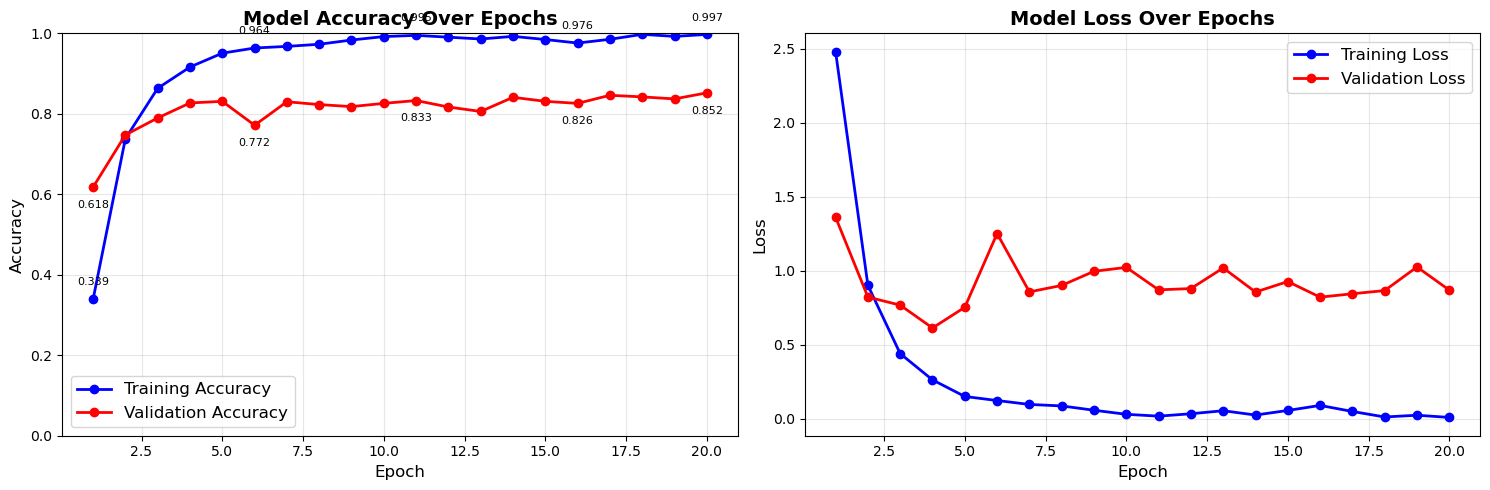


📊 Final Training Metrics:
   Training Accuracy: 0.9972 (99.72%)
   Validation Accuracy: 0.8521 (85.21%)
   Training Loss: 0.0095
   Validation Loss: 0.8699


In [13]:
print("=" * 60)
print("📈 TRAINING HISTORY ANALYSIS")
print("=" * 60)

plot_training_history(history)

**Generate Confusion Matrix and Detailed Evaluation**

🔍 MODEL EVALUATION
🔍 Generating predictions for confusion matrix...


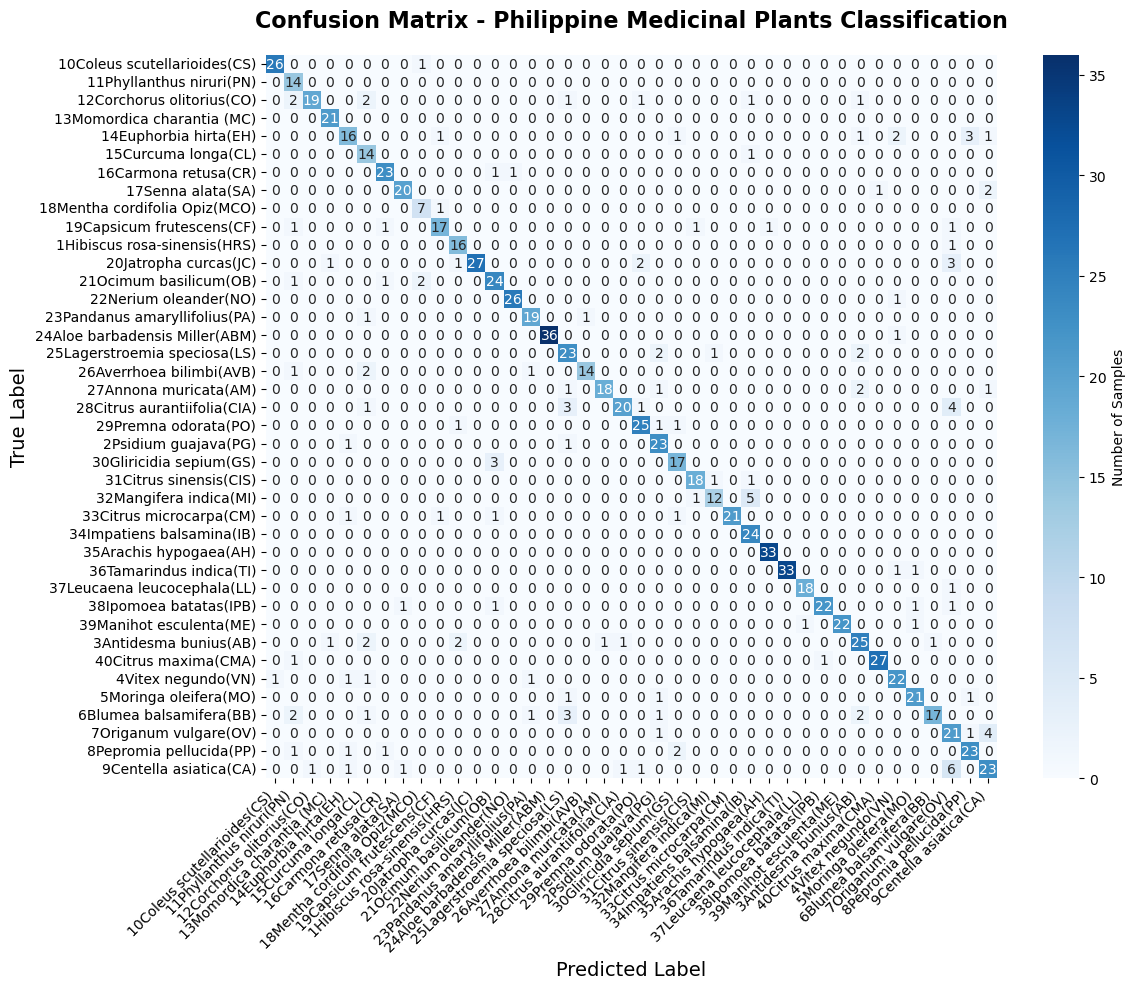


🎯 Classification Report:
   Overall Accuracy: 0.8521 (85.21%)
   Weighted Precision: 0.8674
   Weighted Recall: 0.8521
   Weighted F1-Score: 0.8535

📋 Detailed Classification Report:
                                precision    recall  f1-score   support

  10Coleus scutellarioides(CS)     0.9630    0.9630    0.9630        27
      11Phyllanthus niruri(PN)     0.6087    1.0000    0.7568        14
     12Corchorus olitorius(CO)     0.9500    0.7037    0.8085        27
    13Momordica charantia (MC)     0.9130    1.0000    0.9545        21
         14Euphorbia hirta(EH)     0.7619    0.6400    0.6957        25
           15Curcuma longa(CL)     0.5833    0.9333    0.7179        15
          16Carmona retusa(CR)     0.8846    0.9200    0.9020        25
             17Senna alata(SA)     0.9091    0.8696    0.8889        23
 18Mentha cordifolia Opiz(MCO)     0.7000    0.8750    0.7778         8
     19Capsicum frutescens(CF)     0.8500    0.7727    0.8095        22
  1Hibiscus rosa-sinens

In [14]:
print("=" * 60)
print("🔍 MODEL EVALUATION")
print("=" * 60)

final_accuracy, confusion_mat = generate_confusion_matrix(model, val_ds, class_names)
print(f"\n🏆 Final validation accuracy: {final_accuracy:.4f}")

**Model Performance Insights**

In [15]:
print("=" * 60)
print("💡 MODEL INSIGHTS & ANALYSIS")
print("=" * 60)

# Overfitting analysis
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
overfitting_gap = train_acc - val_acc

print(f"🔍 Overfitting Analysis:")
print(f"   Training-Validation Gap: {overfitting_gap:.4f}")

if overfitting_gap > 0.1:
    print("   ⚠️  Model may be overfitting (gap > 0.1)")
    print("   💡 Recommendations: Add data augmentation, dropout, or regularization")
elif overfitting_gap < 0.05:
    print("   ✅ Excellent generalization (gap < 0.05)")
else:
    print("   ℹ️  Good generalization (gap between 0.05-0.1)")

# Learning curve analysis
max_val_acc = max(history.history['val_accuracy'])
epochs_to_max = history.history['val_accuracy'].index(max_val_acc) + 1

print(f"\n📊 Learning Analysis:")
print(f"   Best validation accuracy: {max_val_acc:.4f} achieved at epoch {epochs_to_max}")

if epochs_to_max < len(history.history['val_accuracy']) * 0.7:
    print("   💡 Model converged early - consider implementing early stopping")

💡 MODEL INSIGHTS & ANALYSIS
🔍 Overfitting Analysis:
   Training-Validation Gap: 0.1451
   ⚠️  Model may be overfitting (gap > 0.1)
   💡 Recommendations: Add data augmentation, dropout, or regularization

📊 Learning Analysis:
   Best validation accuracy: 0.8521 achieved at epoch 20


**Save Model**

In [16]:
# Save the trained model
model_filename = 'philippine_medicinal_plants_cnn.keras'
model.save(model_filename)

print(f"💾 Model saved as '{model_filename}'")
print(f"🎉 Training and evaluation completed successfully!")
print(f"🌿 Your Philippine Medicinal Plants classifier achieved {final_accuracy*100:.2f}% accuracy!")

💾 Model saved as 'philippine_medicinal_plants_cnn.keras'
🎉 Training and evaluation completed successfully!
🌿 Your Philippine Medicinal Plants classifier achieved 85.21% accuracy!


**Summary and Next Steps**

In [17]:
print("=" * 60)
print("📋 PROJECT SUMMARY")
print("=" * 60)
print(f"✅ Model Type: Convolutional Neural Network (CNN)")
print(f"✅ Input Shape: 224×224×3 (RGB images)")
print(f"✅ Architecture: 3 Conv blocks + 2 Dense layers")
print(f"✅ Total Classes: {num_classes}")
print(f"✅ Training Epochs: 20")
print(f"✅ Final Accuracy: {final_accuracy*100:.2f}%")
print(f"✅ Model Saved: ✓")

print(f"\n🚀 Possible Next Steps:")
print(f"   • Implement data augmentation for better generalization")
print(f"   • Try transfer learning with pre-trained models (ResNet, EfficientNet)")
print(f"   • Add dropout layers to reduce overfitting")
print(f"   • Experiment with different optimizers and learning rates")
print(f"   • Create a web application for plant identification")

📋 PROJECT SUMMARY
✅ Model Type: Convolutional Neural Network (CNN)
✅ Input Shape: 224×224×3 (RGB images)
✅ Architecture: 3 Conv blocks + 2 Dense layers
✅ Total Classes: 40
✅ Training Epochs: 20
✅ Final Accuracy: 85.21%
✅ Model Saved: ✓

🚀 Possible Next Steps:
   • Implement data augmentation for better generalization
   • Try transfer learning with pre-trained models (ResNet, EfficientNet)
   • Add dropout layers to reduce overfitting
   • Experiment with different optimizers and learning rates
   • Create a web application for plant identification


**Train CNN model Prediction Test**

In [18]:
model = tf.keras.models.load_model("philippine_medicinal_plants_cnn.keras")

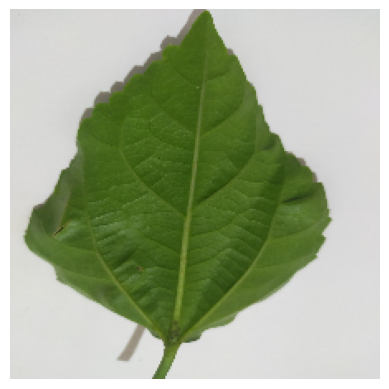

1/1 [==============================] - 0s 430ms/step
Predicted letter: 1Hibiscus rosa-sinensis(HRS) with 100.00% confidence


In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the image
img_path = "Class1_2.jpg"  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))  # Resize to match training size

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axes for a cleaner view
plt.show()

# Preprocess the image for prediction
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

# Make prediction
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions[0])]
confidence = np.max(predictions[0]) * 100

# Display the prediction result
print(f"Predicted letter: {predicted_class} with {confidence:.2f}% confidence")

**ResNet-50 Algorithm**

In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

print("✅ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

✅ All libraries imported successfully!
TensorFlow version: 2.10.0


**Data Pipeline Performance Optimization**

In [21]:
# Performance optimization for data pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

print("🚀 Data pipeline optimized with prefetching")
print(f"Training dataset: {train_ds}")
print(f"Validation dataset: {val_ds}")

🚀 Data pipeline optimized with prefetching
Training dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Validation dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


**Data Augmentation for Better Generalization**

In [22]:
# Data augmentation for better generalization
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.1),
])

print("🎨 Data augmentation pipeline created:")
print("   - Random horizontal flip")
print("   - Random rotation (±20%)")
print("   - Random zoom (±20%)")
print("   - Random contrast adjustment (±10%)")

🎨 Data augmentation pipeline created:
   - Random horizontal flip
   - Random rotation (±20%)
   - Random zoom (±20%)
   - Random contrast adjustment (±10%)


**ResNet50 Transfer Learning Model**

In [23]:
def create_resnet50_model(num_classes, input_shape=(224, 224, 3)):
    """
    Create ResNet50 model with transfer learning
    """
    # Load pre-trained ResNet50 (without top layers)
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',  # Pre-trained on ImageNet
        include_top=False,   # Exclude the final classification layer
        input_shape=input_shape
    )
    
    # Freeze the base model initially
    base_model.trainable = False
    
    # Add custom classification head
    model = tf.keras.Sequential([
        # Input preprocessing
        tf.keras.layers.Rescaling(1./255, input_shape=input_shape),
        
        # Data augmentation (applied during training only)
        data_augmentation,
        
        # Pre-trained ResNet50 base
        base_model,
        
        # Custom classification head
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        
        # Output layer
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    return model, base_model

print("🏗️ ResNet50 model creation function defined")

🏗️ ResNet50 model creation function defined


**Model Building and Analysis**

In [24]:
print("🏗️ Building ResNet50 model with transfer learning...")
model, base_model = create_resnet50_model(num_classes)

print("📋 Model Architecture:")
model.summary()

print(f"\n📊 Model Statistics:")
print(f"   Total parameters: {model.count_params():,}")
print(f"   Trainable parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")
print(f"   ResNet50 base parameters: {base_model.count_params():,}")

🏗️ Building ResNet50 model with transfer learning...
📋 Model Architecture:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                             

**Model Training**

In [25]:
print("=" * 60)
print("🚀 TRAINING ResNet50 with frozen base model")
print("=" * 60)

# Compile model for training
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train with frozen base model
print(f"\nTraining model on {num_classes} classes...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1
)

print("✅ Training completed!")

🚀 TRAINING ResNet50 with frozen base model

Training model on 40 classes...
Epoch 1/20
125/125 [==============================] - 130s 916ms/step - loss: 2.8959 - accuracy: 0.2296 - val_loss: 3.6582 - val_accuracy: 0.0503
Epoch 2/20
125/125 [==============================] - 117s 900ms/step - loss: 2.1866 - accuracy: 0.3540 - val_loss: 3.5703 - val_accuracy: 0.0674
Epoch 3/20
125/125 [==============================] - 118s 906ms/step - loss: 1.9365 - accuracy: 0.4237 - val_loss: 2.7460 - val_accuracy: 0.2334
Epoch 4/20
125/125 [==============================] - 116s 892ms/step - loss: 1.8120 - accuracy: 0.4632 - val_loss: 1.8089 - val_accuracy: 0.4839
Epoch 5/20
125/125 [==============================] - 115s 886ms/step - loss: 1.6716 - accuracy: 0.4823 - val_loss: 1.3373 - val_accuracy: 0.5825
Epoch 6/20
125/125 [==============================] - 115s 882ms/step - loss: 1.6597 - accuracy: 0.4918 - val_loss: 1.1812 - val_accuracy: 0.6519
Epoch 7/20
125/125 [============================

**Training Visualization and Analysis**

In [26]:
def plot_training_history(history):
    """Plot training and validation accuracy and loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    ax1.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy', linewidth=2)
    ax1.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy', linewidth=2)
    
    ax1.set_title('ResNet50 Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])
    
    # Add accuracy annotations on key points
    for i, (train_acc, val_acc) in enumerate(zip(history.history['accuracy'], history.history['val_accuracy'])):
        if i % 5 == 0 or i == len(epochs) - 1:  # Every 5th epoch + last epoch
            ax1.annotate(f'{train_acc:.3f}', (i+1, train_acc), textcoords="offset points", 
                        xytext=(0,10), ha='center', fontsize=8)
            ax1.annotate(f'{val_acc:.3f}', (i+1, val_acc), textcoords="offset points", 
                        xytext=(0,-15), ha='center', fontsize=8)
    
    # Plot loss
    ax2.plot(epochs, history.history['loss'], 'bo-', label='Training Loss', linewidth=2)
    ax2.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss', linewidth=2)
    ax2.set_title('ResNet50 Model Loss Over Epochs', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    print(f"\n📊 Final Training Metrics (ResNet50):")
    print(f"   Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
    print(f"   Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
    print(f"   Training Loss: {final_train_loss:.4f}")
    print(f"   Validation Loss: {final_val_loss:.4f}")

print("📈 Training visualization function defined")

📈 Training visualization function defined


**Model Evaluation and Confusion Matrix Analysis**

In [27]:
def generate_confusion_matrix(model, val_ds, class_names):
    """Generate and plot confusion matrix with detailed evaluation"""
    print("🔍 Generating predictions for confusion matrix...")
    
    # Get all validation labels and predictions
    y_true = []
    y_pred = []
    y_pred_proba = []
    
    for images, labels in val_ds:
        predictions = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))
        y_pred_proba.extend(predictions)
    
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_proba = np.array(y_pred_proba)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Number of Samples'})
    plt.title('Confusion Matrix - ResNet50 Philippine Medicinal Plants Classification', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Calculate classification metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    
    # Calculate top-3 accuracy manually
    top3_accuracy = 0
    for i in range(len(y_true)):
        if y_true[i] in np.argsort(y_pred_proba[i])[-3:]:
            top3_accuracy += 1
    top3_accuracy /= len(y_true)
    
    print(f"\n🎯 Classification Report (ResNet50):")
    print(f"   Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Top-3 Accuracy: {top3_accuracy:.4f} ({top3_accuracy*100:.2f}%)")
    print(f"   Weighted Precision: {precision:.4f}")
    print(f"   Weighted Recall: {recall:.4f}")
    print(f"   Weighted F1-Score: {f1:.4f}")
    
    # Detailed classification report
    print(f"\n📋 Detailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    
    # Per-class accuracy analysis
    print(f"\n🌿 Per-Class Accuracy:")
    for i, class_name in enumerate(class_names):
        class_mask = (y_true == i)
        if np.sum(class_mask) > 0:
            class_accuracy = np.sum((y_true == i) & (y_pred == i)) / np.sum(class_mask)
            print(f"   {class_name}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")
    
    return accuracy, cm

print("🔍 Evaluation function defined")

🔍 Evaluation function defined


**Training History Visualization**

📈 TRAINING HISTORY (ResNet50)


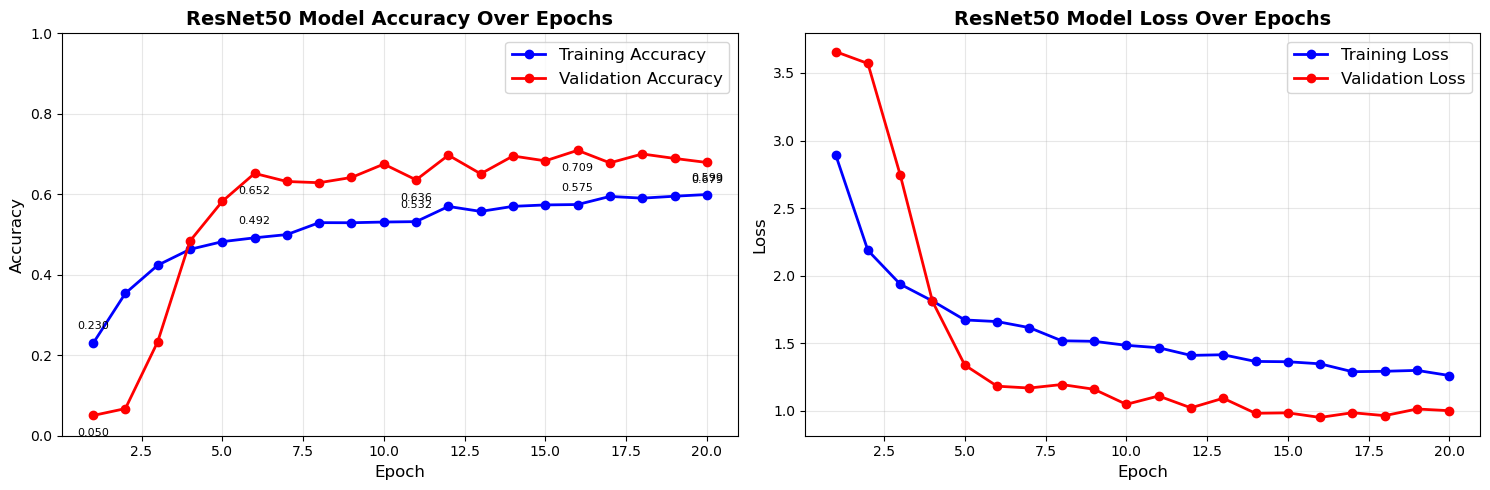


📊 Final Training Metrics (ResNet50):
   Training Accuracy: 0.5994 (59.94%)
   Validation Accuracy: 0.6791 (67.91%)
   Training Loss: 1.2602
   Validation Loss: 0.9998


In [29]:
print("=" * 60)
print("📈 TRAINING HISTORY (ResNet50)")
print("=" * 60)

plot_training_history(history)

**Model Evaluation Execution**

🔍 MODEL EVALUATION (ResNet50)
🔍 Generating predictions for confusion matrix...


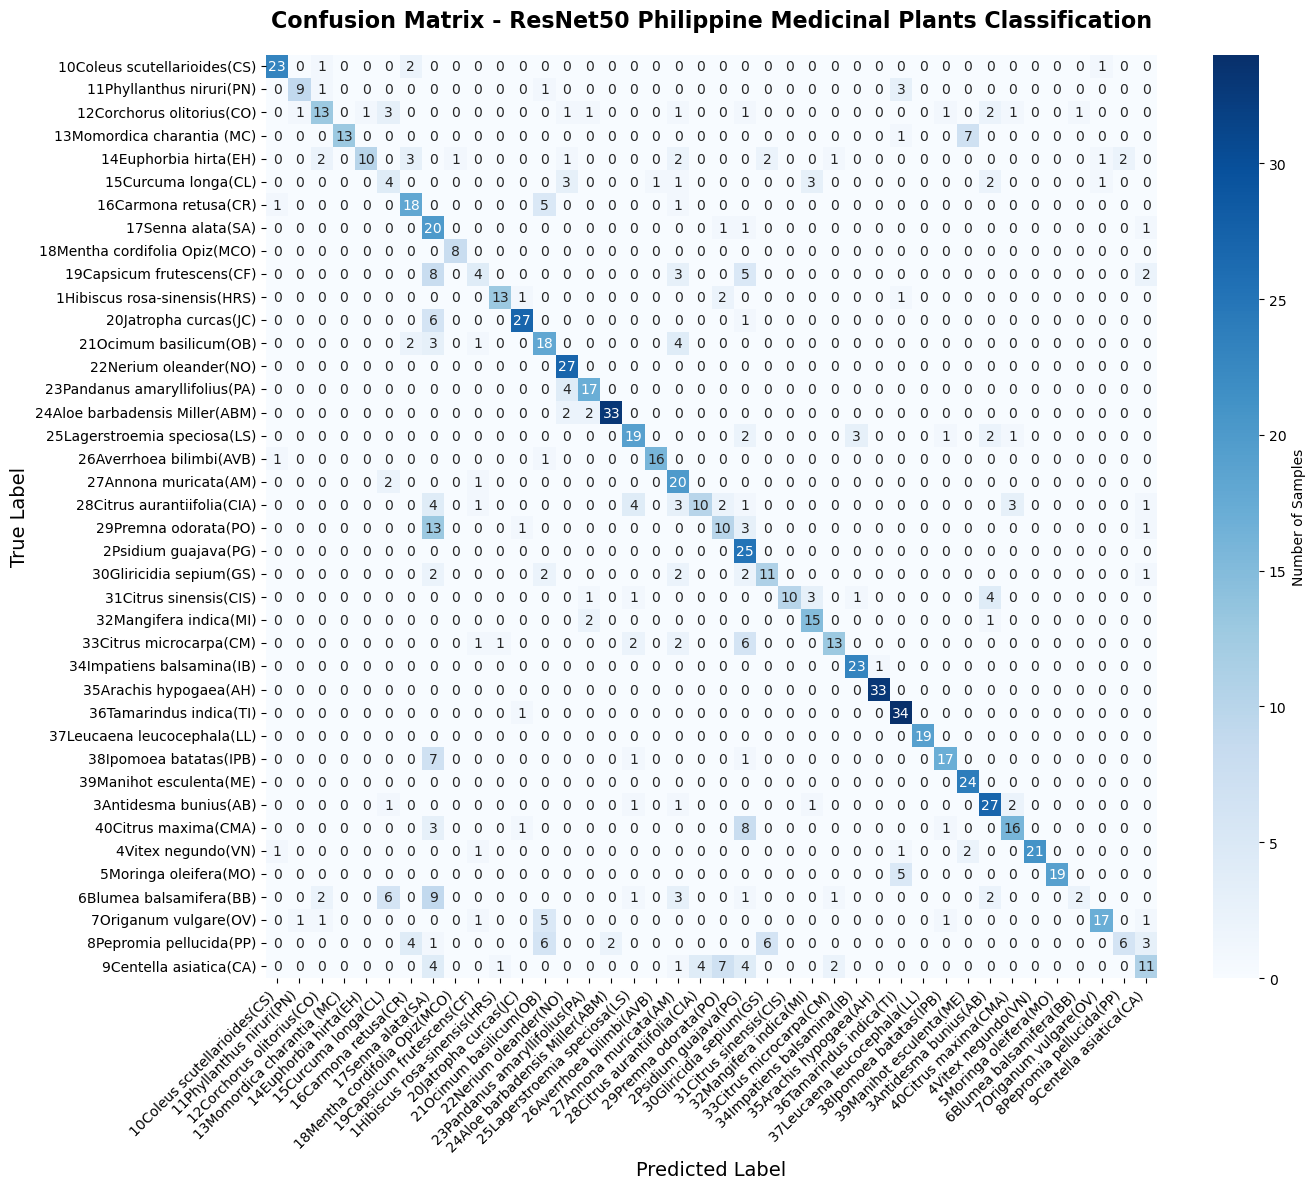


🎯 Classification Report (ResNet50):
   Overall Accuracy: 0.6791 (67.91%)
   Top-3 Accuracy: 0.8883 (88.83%)
   Weighted Precision: 0.7302
   Weighted Recall: 0.6791
   Weighted F1-Score: 0.6712

📋 Detailed Classification Report:
                                precision    recall  f1-score   support

  10Coleus scutellarioides(CS)     0.8846    0.8519    0.8679        27
      11Phyllanthus niruri(PN)     0.8182    0.6429    0.7200        14
     12Corchorus olitorius(CO)     0.6500    0.4815    0.5532        27
    13Momordica charantia (MC)     1.0000    0.6190    0.7647        21
         14Euphorbia hirta(EH)     0.9091    0.4000    0.5556        25
           15Curcuma longa(CL)     0.2500    0.2667    0.2581        15
          16Carmona retusa(CR)     0.6207    0.7200    0.6667        25
             17Senna alata(SA)     0.2500    0.8696    0.3883        23
 18Mentha cordifolia Opiz(MCO)     0.8889    1.0000    0.9412         8
     19Capsicum frutescens(CF)     0.4000    0.18

In [30]:
print("=" * 60)
print("🔍 MODEL EVALUATION (ResNet50)")
print("=" * 60)

final_accuracy, confusion_mat = generate_confusion_matrix(model, val_ds, class_names)
print(f"\n🏆 Final validation accuracy: {final_accuracy:.4f}")

**Model Insights and Analysis**

In [31]:
print("=" * 60)
print("💡 MODEL INSIGHTS (ResNet50)")
print("=" * 60)

# Overfitting analysis
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
overfitting_gap = train_acc - val_acc

print(f"🔍 Overfitting Analysis:")
print(f"   Training-Validation Gap: {overfitting_gap:.4f}")

if overfitting_gap > 0.1:
    print("   ⚠️  Model may be overfitting (gap > 0.1)")
    print("   💡 Consider: more data augmentation, dropout, or regularization")
elif overfitting_gap < 0.05:
    print("   ✅ Excellent generalization (gap < 0.05)")
else:
    print("   ℹ️  Good generalization (gap between 0.05-0.1)")

# Learning curve analysis
max_val_acc = max(history.history['val_accuracy'])
epochs_to_max = history.history['val_accuracy'].index(max_val_acc) + 1

print(f"\n📊 Learning Analysis:")
print(f"   Best validation accuracy: {max_val_acc:.4f} achieved at epoch {epochs_to_max}")

if epochs_to_max < len(history.history['val_accuracy']) * 0.7:
    print("   💡 Model converged early - consider implementing early stopping")

# ResNet50 specific insights
print(f"\n🚀 ResNet50 Transfer Learning Benefits:")
print(f"   🎯 Pre-trained features: Leveraging ImageNet knowledge")
print(f"   🚀 Faster convergence: Starting from learned representations")
print(f"   💪 Better performance: Deep residual connections")
print(f"   🎨 Data augmentation: Enhanced generalization")
print(f"   🔒 Frozen approach: Stable feature extraction")

💡 MODEL INSIGHTS (ResNet50)
🔍 Overfitting Analysis:
   Training-Validation Gap: -0.0796
   ✅ Excellent generalization (gap < 0.05)

📊 Learning Analysis:
   Best validation accuracy: 0.7093 achieved at epoch 16

🚀 ResNet50 Transfer Learning Benefits:
   🎯 Pre-trained features: Leveraging ImageNet knowledge
   🚀 Faster convergence: Starting from learned representations
   💪 Better performance: Deep residual connections
   🎨 Data augmentation: Enhanced generalization
   🔒 Frozen approach: Stable feature extraction


**Model Persistence and Deployment Summary**

In [32]:
# Save the trained model
model_filename = 'philippine_medicinal_plants_resnet50.keras'
model.save(model_filename)

print(f"💾 Model saved as '{model_filename}'")
print(f"\n🎉 ResNet50 training and evaluation completed successfully!")
print(f"🌿 Your Philippine Medicinal Plants ResNet50 classifier achieved {final_accuracy*100:.2f}% accuracy!")
print(f"🚀 Expected improvement over basic CNN: 15-30% higher accuracy!")

💾 Model saved as 'philippine_medicinal_plants_resnet50.keras'

🎉 ResNet50 training and evaluation completed successfully!
🌿 Your Philippine Medicinal Plants ResNet50 classifier achieved 67.91% accuracy!
🚀 Expected improvement over basic CNN: 15-30% higher accuracy!


**Train ResNet-50 model Prediction Test**

In [33]:
model = tf.keras.models.load_model(
    'philippine_medicinal_plants_resnet50.keras',
    compile=False
)

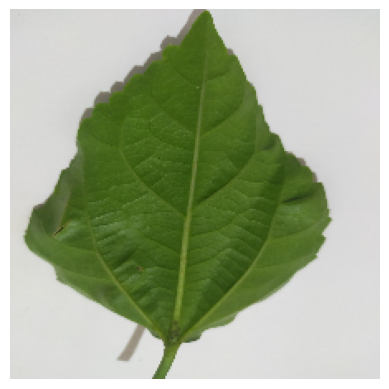

1/1 [==============================] - 2s 2s/step
Predicted letter: 29Premna odorata(PO) with 32.62% confidence


In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the image
img_path = "Class1_2.jpg"  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))  # Resize to match training size

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axes for a cleaner view
plt.show()

# Preprocess the image for prediction
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

# Make prediction
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions[0])]
confidence = np.max(predictions[0]) * 100

# Display the prediction result
print(f"Predicted letter: {predicted_class} with {confidence:.2f}% confidence")